In [2]:
import os
import json
import torch

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import transformers
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix, roc_auc_score
from datasets import DatasetDict
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
from glob import glob
from torch.utils.data import DataLoader

import torch.nn.functional as F

# Configuración de dispositivo (GPU o CPU)
device = "cuda" if torch.cuda.is_available() else "cpu"
# device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
device

c:\Users\aleja\Documents\github\NLP\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'cuda'

In [3]:
# @title Customize your key variables here
# Sections of config

# Defining some key variables that will be used later on in the training
MAX_LEN = 512 # @param {type:"integer"}
TRAIN_BATCH_SIZE = 32 # @param {type:"integer"}
VALID_BATCH_SIZE = 32 # @param {type:"integer"}
EPOCHS = 4 # @param {type:"integer"}
LEARNING_RATE = 1e-5 # @param {type:"number"}

In [4]:
machines_files = glob('./data/machine/*.jsonl')
len(machines_files)

13

In [5]:
df_ids = pd.read_json('./data/human.jsonl', lines=True)
df_ids = df_ids[['id']]
df_ids["id"] = df_ids["id"].str.split('/').str[1:].str.join('/')
df_ids

,id
0,news-2021-01-01-2021-12-31-bideninauguration/a...
1,news-2021-01-01-2021-12-31-bideninauguration/a...
2,news-2021-01-01-2021-12-31-bideninauguration/a...
3,news-2021-01-01-2021-12-31-bideninauguration/a...
4,news-2021-01-01-2021-12-31-bideninauguration/a...
...,...
1082,news-2021-01-01-2021-12-31-wyominggabbypetito/...
1083,news-2021-01-01-2021-12-31-wyominggabbypetito/...
1084,news-2021-01-01-2021-12-31-wyominggabbypetito/...
1085,news-2021-01-01-2021-12-31-wyominggabbypetito/...


In [6]:
train_ids_df, temp_df = train_test_split(df_ids, test_size=0.3, random_state=42)
val_ids_df, test_ids_df = train_test_split(temp_df, test_size=1/3, random_state=42)

train_ids_df.shape, val_ids_df.shape, test_ids_df.shape

((760, 1), (218, 1), (109, 1))

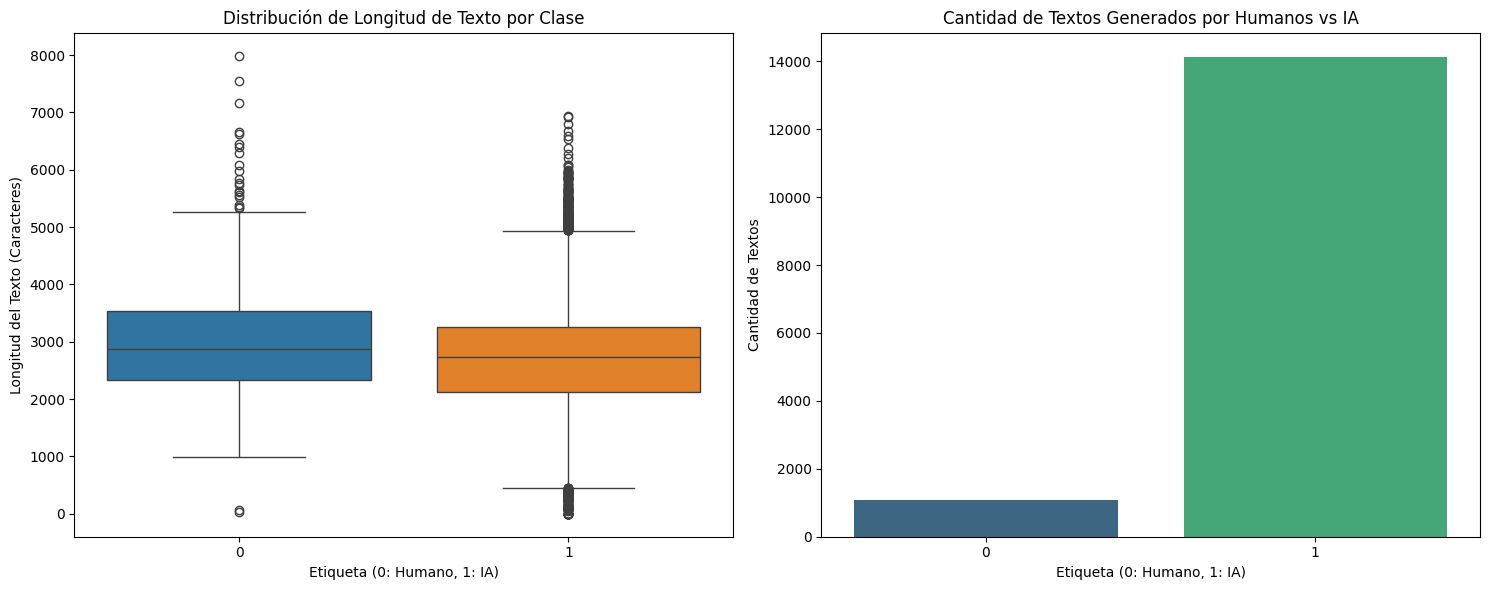

In [7]:
df_human = pd.read_json('./data/human.jsonl', lines=True)

df_human_temp = df_human.reset_index(drop=True)
df_human_temp['label'] = 0

df_machine = pd.read_json(machines_files[0], lines=True)
for file in machines_files[1:]:
    df_current = pd.read_json(file, lines=True)
    df_machine = pd.concat([df_machine, df_current])

df_machine_temp = df_machine.reset_index(drop=True)
df_machine_temp['label'] = 1


df_temp = pd.concat([df_human_temp, df_machine_temp], axis=0, ignore_index=True)

# Calcular la longitud del texto en la columna 'text'
df_temp["text_length"] = df_temp["text"].apply(len)

# Crear una figura con 2 subgráficos (uno al lado del otro)
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

# 1. Gráfico de la longitud del texto (sin `palette`)
sns.boxplot(data=df_temp, x="label", hue="label",y="text_length", ax=ax[0], legend=False)
ax[0].set_title("Distribución de Longitud de Texto por Clase")
ax[0].set_xlabel("Etiqueta (0: Humano, 1: IA)")
ax[0].set_ylabel("Longitud del Texto (Caracteres)")

# 2. Gráfico de la cantidad de texto generado por IA y Humanos
sns.countplot(data=df_temp, x="label", hue="label", palette="viridis", ax=ax[1], legend=False)
ax[1].set_title("Cantidad de Textos Generados por Humanos vs IA")
ax[1].set_xlabel("Etiqueta (0: Humano, 1: IA)")
ax[1].set_ylabel("Cantidad de Textos")

# Mostrar los gráficos
plt.tight_layout()
plt.show()

In [8]:
df_human["id"] = df_human["id"].str.split('/').str[1:].str.join('/')
df_machine["id"] = df_machine["id"].str.split('/').str[1:].str.join('/')

df_combined = pd.merge(df_human, df_machine, on="id", suffixes=("_1", "_2"))
df_combined['target_human'] = 1
df_combined['target_machine'] = 0
df_combined = df_combined[['id', 'text_1', 'target_human', 'text_2', 'target_machine']]
df_combined

,id,text_1,target_human,text_2,target_machine
0,news-2021-01-01-2021-12-31-bideninauguration/a...,Inaugural Address by President Joseph R. Biden...,1,Inaugural Address: President Joseph R. Biden J...,0
1,news-2021-01-01-2021-12-31-bideninauguration/a...,Inaugural Address by President Joseph R. Biden...,1,What should be the focus of the speech? The In...,0
2,news-2021-01-01-2021-12-31-bideninauguration/a...,Inaugural Address by President Joseph R. Biden...,1,Biden's Inaugural Address Highlights Triumph o...,0
3,news-2021-01-01-2021-12-31-bideninauguration/a...,Inaugural Address by President Joseph R. Biden...,1,Biden's Inaugural Address: A Clarion Call for ...,0
4,news-2021-01-01-2021-12-31-bideninauguration/a...,Inaugural Address by President Joseph R. Biden...,1,"President Biden Emphasizes Unity, Democracy, a...",0
...,...,...,...,...,...
14126,news-2021-01-01-2021-12-31-wyominggabbypetito/...,Gabby Petito case: Surf shop owner in her home...,1,Gabby Petito: Long Island Surf Shop Owner Reme...,0
14127,news-2021-01-01-2021-12-31-wyominggabbypetito/...,Gabby Petito case: Surf shop owner in her home...,1,Gabby Petito: Surf Shop Owner in Hometown Reme...,0
14128,news-2021-01-01-2021-12-31-wyominggabbypetito/...,Gabby Petito case: Surf shop owner in her home...,1,Gabby Petito Remembered as a 'Kind-Hearted Sou...,0
14129,news-2021-01-01-2021-12-31-wyominggabbypetito/...,Gabby Petito case: Surf shop owner in her home...,1,Gabby Petito Remembered as a 'Super Kind-Heart...,0


In [9]:
random_indices = df_combined.sample(frac=0.5, random_state=42).index
df_combined.loc[random_indices, ['text_1', 'text_2']] = df_combined.loc[random_indices, ['text_2', 'text_1']].values
df_combined.loc[random_indices, ['target_human']] = 0
df_combined.loc[random_indices, ['target_machine']] = 1
df_combined['target_tuple'] = list(zip(df_combined['target_human'], df_combined['target_machine']))
df_combined = df_combined[['id', 'text_1', 'target_human', 'text_2', 'target_machine', 'target_tuple']]
df_combined

,id,text_1,target_human,text_2,target_machine,target_tuple
0,news-2021-01-01-2021-12-31-bideninauguration/a...,Inaugural Address: President Joseph R. Biden J...,0,Inaugural Address by President Joseph R. Biden...,1,"(0, 1)"
1,news-2021-01-01-2021-12-31-bideninauguration/a...,Inaugural Address by President Joseph R. Biden...,1,What should be the focus of the speech? The In...,0,"(1, 0)"
2,news-2021-01-01-2021-12-31-bideninauguration/a...,Inaugural Address by President Joseph R. Biden...,1,Biden's Inaugural Address Highlights Triumph o...,0,"(1, 0)"
3,news-2021-01-01-2021-12-31-bideninauguration/a...,Biden's Inaugural Address: A Clarion Call for ...,0,Inaugural Address by President Joseph R. Biden...,1,"(0, 1)"
4,news-2021-01-01-2021-12-31-bideninauguration/a...,Inaugural Address by President Joseph R. Biden...,1,"President Biden Emphasizes Unity, Democracy, a...",0,"(1, 0)"
...,...,...,...,...,...,...
14126,news-2021-01-01-2021-12-31-wyominggabbypetito/...,Gabby Petito: Long Island Surf Shop Owner Reme...,0,Gabby Petito case: Surf shop owner in her home...,1,"(0, 1)"
14127,news-2021-01-01-2021-12-31-wyominggabbypetito/...,Gabby Petito case: Surf shop owner in her home...,1,Gabby Petito: Surf Shop Owner in Hometown Reme...,0,"(1, 0)"
14128,news-2021-01-01-2021-12-31-wyominggabbypetito/...,Gabby Petito case: Surf shop owner in her home...,1,Gabby Petito Remembered as a 'Kind-Hearted Sou...,0,"(1, 0)"
14129,news-2021-01-01-2021-12-31-wyominggabbypetito/...,Gabby Petito Remembered as a 'Super Kind-Heart...,0,Gabby Petito case: Surf shop owner in her home...,1,"(0, 1)"


In [10]:
X_train = df_combined[df_combined['id'].isin(train_ids_df['id'])].drop(columns=['id', 'target_human', 'target_machine'])
X_val = df_combined[df_combined['id'].isin(val_ids_df['id'])].drop(columns=['id', 'target_human', 'target_machine'])
X_test = df_combined[df_combined['id'].isin(test_ids_df['id'])].drop(columns=['id', 'target_human', 'target_machine'])

X_train.shape, X_val.shape, X_test.shape

((9880, 3), (2834, 3), (1417, 3))

In [11]:
X_train.sample(5)

,text_1,text_2,target_tuple
9912,"'Rust' Executive Producer Defends Involvement,...",'Rust' Producer Says It Was in 'Good Standing'...,"(0, 1)"
3902,COVID-19 Vaccines: Clinical Trials Confirm Saf...,"COVID-19 Vaccine Safety\n\nOver the past year,...","(0, 1)"
6589,Summer storms were a climate-change wake-up ca...,East Coast Transit Systems Grapple with Climat...,"(1, 0)"
8350,Gun store promotes 'not guilty' sale after Rit...,Gun Store Announces 'Not Guilty' Sale Followin...,"(1, 0)"
225,"Yes, Biden's inauguration was legitimate. No, ...",Biden's Inauguration: Debunking Claims of Fake...,"(1, 0)"


In [12]:
y_train = X_train['target_tuple']
y_val = X_val['target_tuple']
y_test = X_test['target_tuple']

X_train = X_train.drop(columns=['target_tuple'])
X_val = X_val.drop(columns=['target_tuple'])
X_test = X_test.drop(columns=['target_tuple'])

y_train.shape, y_val.shape, y_test.shape

((9880,), (2834,), (1417,))

In [13]:
X_train

,text_1,text_2
0,Inaugural Address: President Joseph R. Biden J...,Inaugural Address by President Joseph R. Biden...
1,Inaugural Address by President Joseph R. Biden...,What should be the focus of the speech? The In...
2,Inaugural Address by President Joseph R. Biden...,Biden's Inaugural Address Highlights Triumph o...
3,Biden's Inaugural Address: A Clarion Call for ...,Inaugural Address by President Joseph R. Biden...
4,Inaugural Address by President Joseph R. Biden...,"President Biden Emphasizes Unity, Democracy, a..."
...,...,...
14100,Univ. of Wisconsin Oshkosh student helping Gab...,University of Wisconsin Oshkosh Student Claims...
14101,TESLA STOCK SOARS ON Q3 EARNINGS REPORT\n\nWYO...,Univ. of Wisconsin Oshkosh student helping Gab...
14102,WYOMING (WBAY) – A University of Wisconsin Osh...,Univ. of Wisconsin Oshkosh student helping Gab...
14103,Univ. of Wisconsin Oshkosh student helping Gab...,University of Wisconsin Oshkosh Student Claims...


In [14]:
pd.DataFrame(y_train)

,target_tuple
0,"(0, 1)"
1,"(1, 0)"
2,"(1, 0)"
3,"(0, 1)"
4,"(1, 0)"
...,...
14100,"(1, 0)"
14101,"(0, 1)"
14102,"(0, 1)"
14103,"(1, 0)"


In [15]:
class AiClassificationDataset(Dataset):
    def __init__(self, dataframe, labels):
        self.data = dataframe.reset_index(drop=True)
        self.labels = labels.reset_index(drop=True)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        # Use iloc to access the rows by index for data and labels
        text_1 = self.data.iloc[index]['text_1']
        text_2 = self.data.iloc[index]['text_2']
        target = self.labels.iloc[index]  # assuming labels are in a compatible format
        return {
            'text_1': text_1,
            'text_2': text_2,
            'targets': target
        }

In [16]:
class AiClassificationCollator:
    def __init__(self, dataset, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataset
        self.max_len = max_len

    def __call__(self, input_batch):
        batch_dict = {colname: [x[colname] for x in input_batch] for colname in input_batch[0]}

        # Process text_1
        comment_text_1 = batch_dict['text_1']
        comment_text_1 = [" ".join(text.split()) for text in comment_text_1]

        # Process text_2
        comment_text_2 = batch_dict['text_2']
        comment_text_2 = [" ".join(text.split()) for text in comment_text_2]

        inputs = self.tokenizer(
            comment_text_1,
            comment_text_2,
            max_length=self.max_len,
            padding=True,
            truncation=True,
            return_token_type_ids=True
        )

        return {
            'ids': torch.tensor(inputs['input_ids'], dtype=torch.long),
            'mask': torch.tensor(inputs['attention_mask'], dtype=torch.long),
            'token_type_ids': torch.tensor(inputs['token_type_ids'], dtype=torch.long),
            'targets': torch.tensor(batch_dict['targets'], dtype=torch.float)
        }

In [17]:
tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-large-uncased")

c:\Users\aleja\Documents\github\NLP\.venv\Lib\site-packages\huggingface_hub\file_download.py:139: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\aleja\.cache\huggingface\hub\models--google-bert--bert-large-uncased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


In [18]:
training_set = AiClassificationDataset(X_train, y_train)
validation_set = AiClassificationDataset(X_val, y_val)
test_set = AiClassificationDataset(X_test, y_test)

train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0,
                'collate_fn': AiClassificationCollator(training_set, tokenizer, MAX_LEN)
                }

val_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': False,
                'num_workers': 0,
                'collate_fn': AiClassificationCollator(validation_set, tokenizer, MAX_LEN)
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': False,
                'num_workers': 0,
                'collate_fn': AiClassificationCollator(test_set, tokenizer, MAX_LEN)
                }

training_loader = DataLoader(training_set, **train_params)
validation_loader = DataLoader(validation_set, **val_params)
test_loader = DataLoader(test_set, **test_params)

In [19]:
for batch in training_loader:
    print("Training Loader Batch:")
    if isinstance(batch, dict):  
        for key, value in batch.items():
            if hasattr(value, 'shape'):
                print(f"{key}: {value.shape}")
            else:
                print(f"{key}: {type(value)}")
    elif isinstance(batch, (list, tuple)):  
        for i, item in enumerate(batch):
            if hasattr(item, 'shape'):
                print(f"Item {i}: {item.shape}")
            else:
                print(f"Item {i}: {type(item)}")
    break  

for batch in validation_loader:
    print("\nValidation Loader Batch:")
    if isinstance(batch, dict):
        for key, value in batch.items():
            if hasattr(value, 'shape'):
                print(f"{key}: {value.shape}")
            else:
                print(f"{key}: {type(value)}")
    elif isinstance(batch, (list, tuple)):
        for i, item in enumerate(batch):
            if hasattr(item, 'shape'):
                print(f"Item {i}: {item.shape}")
            else:
                print(f"Item {i}: {type(item)}")
    break

for batch in test_loader:
    print("\nTest Loader Batch:")
    if isinstance(batch, dict):
        for key, value in batch.items():
            if hasattr(value, 'shape'):
                print(f"{key}: {value.shape}")
            else:
                print(f"{key}: {type(value)}")
    elif isinstance(batch, (list, tuple)):
        for i, item in enumerate(batch):
            if hasattr(item, 'shape'):
                print(f"Item {i}: {item.shape}")
            else:
                print(f"Item {i}: {type(item)}")
    break


Training Loader Batch:
ids: torch.Size([32, 512])
mask: torch.Size([32, 512])
token_type_ids: torch.Size([32, 512])
targets: torch.Size([32, 2])

Validation Loader Batch:
ids: torch.Size([32, 512])
mask: torch.Size([32, 512])
token_type_ids: torch.Size([32, 512])
targets: torch.Size([32, 2])

Test Loader Batch:
ids: torch.Size([32, 512])
mask: torch.Size([32, 512])
token_type_ids: torch.Size([32, 512])
targets: torch.Size([32, 2])


In [42]:
class TransformerClass(torch.nn.Module):
    def __init__(self):
        super(TransformerClass, self).__init__()
        self.l1 = transformers.BertModel.from_pretrained('google-bert/bert-large-uncased')
        self.l2 = torch.nn.Dropout(0.3)
        self.l3 = torch.nn.Linear(1024, 256)
        self.l4 = torch.nn.Linear(256, 2)

    def forward(self, ids, mask, token_type_ids):
        last_hidden_state = self.l1(
            ids,
            attention_mask=mask,
            token_type_ids=token_type_ids
        ).last_hidden_state

        cls_token = last_hidden_state[:, 0]
        hidden_output = F.gelu(self.l3(self.l2(cls_token)))
        output = self.l4(hidden_output)

        return output

In [21]:
def training_step(input_ids, attention_mask, token_type_ids, y, model, optimizer):
    logits = model(input_ids, attention_mask, token_type_ids)
    optimizer.zero_grad()

    loss = torch.nn.functional.cross_entropy(logits, y, reduction='mean')
    loss.backward()
    
    optimizer.step()

    return loss

In [22]:
model = TransformerClass()
model.to(device)

optimizer = torch.optim.Adam(params=model.parameters(), lr=LEARNING_RATE)

In [23]:
def validate():
    model.eval()
    val_loss = 0
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():
        for data in validation_loader:
            input_ids = data['ids'].to(device)
            attention_mask = data['mask'].to(device)
            token_type_ids = data['token_type_ids'].to(device)
            targets = data['targets'].to(device)

            logits = model(input_ids, attention_mask, token_type_ids)
            val_loss += torch.nn.functional.cross_entropy(logits, targets, reduction='sum').item()  # Accumulate validation loss

            preds = torch.argmax(logits, dim=1)
            correct_predictions += (preds == targets.argmax(dim=1)).sum().item()
            total_predictions += targets.size(0)

    avg_val_loss = val_loss / total_predictions
    accuracy = correct_predictions / total_predictions
    return avg_val_loss, accuracy


In [ ]:
train_losses_step = []  # Pérdidas por paso
val_losses = []  # Pérdidas de validación

def train(epoch, log_interval=200, save_model_path='./model_weights'):
    global best_accuracy
    model.train()
    running_loss = 0

    for step, data in enumerate(training_loader):
        input_ids = data['ids'].to(device)
        attention_mask = data['mask'].to(device)
        token_type_ids = data['token_type_ids'].to(device)
        targets = data['targets'].to(device)

        loss = training_step(input_ids, attention_mask, token_type_ids, targets, model, optimizer)
        running_loss += loss.item()

        # Almacenar la pérdida cada cierto número de pasos
        if step % log_interval == 0:
            avg_loss = running_loss / (step + 1)
            print(f"Epoch {epoch + 1}/{EPOCHS}, Step {step + 1}/{len(training_loader)}")
            print(f"  Running Loss: {avg_loss:.4f}")
            train_losses_step.append(avg_loss)  # Almacenar la pérdida por paso

    avg_train_loss = running_loss / len(training_loader)

    avg_val_loss, val_accuracy = validate()

    print(f"Epoch {epoch + 1}/{EPOCHS} - End of epoch")
    print(f"  Training Loss: {avg_train_loss:.4f}")
    print(f"  Validation Loss: {avg_val_loss:.4f}")
    print(f"  Validation Accuracy: {val_accuracy:.4f}")

    val_losses.append(avg_val_loss)  # Almacenar la pérdida de validación

    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        if not os.path.exists(save_model_path):
            os.makedirs(save_model_path)

        model_save_path = os.path.join(save_model_path, f"model_epoch_{epoch + 1}_acc{best_accuracy:.4f}.pth")
        torch.save(model.state_dict(), model_save_path)
        print(f"Model saved to {model_save_path}")

best_accuracy = 0

"""Descomentar para entrenar"""
# for epoch in range(EPOCHS):
#       train(epoch)

file_path = f'logs\BERT_L_CLS_training_logs.txt'

with open(file_path, 'r') as file:
    content = file.read()

print(content)

Epoch 1/4, Step 1/309
  Running Loss: 0.7003
Epoch 1/4, Step 201/309
  Running Loss: 0.2084
Epoch 1/4 - End of epoch
  Training Loss: 0.1430
  Validation Loss: 0.0242
  Validation Accuracy: 0.9933
Model saved to ./model_weights/model_epoch_1_acc0.9933.pth
Epoch 2/4, Step 1/309
  Running Loss: 0.0039
Epoch 2/4, Step 201/309
  Running Loss: 0.0099
Epoch 2/4 - End of epoch
  Training Loss: 0.0086
  Validation Loss: 0.0123
  Validation Accuracy: 0.9965
Model saved to ./model_weights/model_epoch_2_acc0.9965.pth
Epoch 3/4, Step 1/309
  Running Loss: 0.0030
Epoch 3/4, Step 201/309
  Running Loss: 0.0080
Epoch 3/4 - End of epoch
  Training Loss: 0.0073
  Validation Loss: 0.0302
  Validation Accuracy: 0.9919
Epoch 4/4, Step 1/309
  Running Loss: 0.0008
Epoch 4/4, Step 201/309
  Running Loss: 0.0015
Epoch 4/4 - End of epoch
  Training Loss: 0.0018
  Validation Loss: 0.0505
  Validation Accuracy: 0.9852



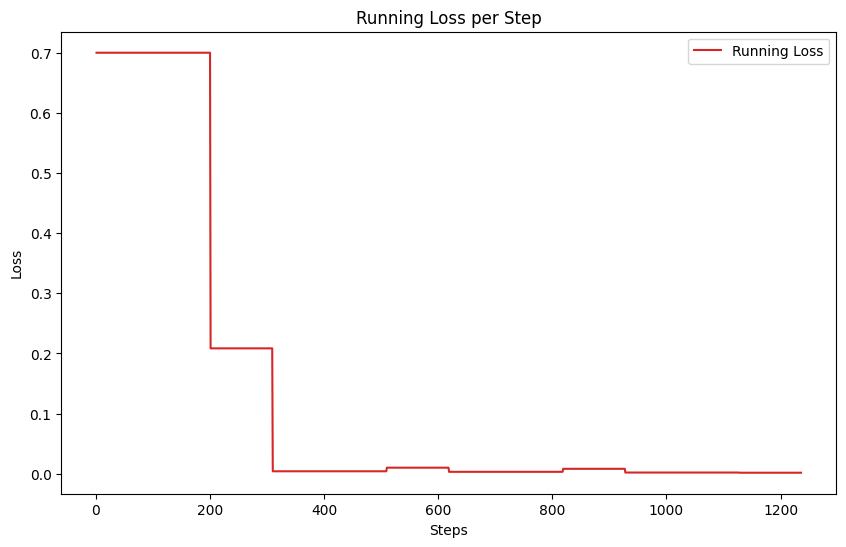

In [39]:
epochs = 4
steps_per_epoch = 309

running_loss_epoch_1 = [0.7003] * 200 + [0.2084] * 109  
running_loss_epoch_2 = [0.0039] * 200 + [0.0099] * 109 
running_loss_epoch_3 = [0.0030] * 200 + [0.0080] * 109 
running_loss_epoch_4 = [0.0018] * 200 + [0.0015] * 109

all_steps = np.arange(1, steps_per_epoch * epochs + 1)
all_losses = running_loss_epoch_1 + running_loss_epoch_2 + running_loss_epoch_3 + running_loss_epoch_4

# Graficar las pérdidas
plt.figure(figsize=(10, 6))
plt.plot(all_steps, all_losses, label='Running Loss', color='tab:red')

# Añadir etiquetas y título
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Running Loss per Step')
plt.legend()

# Mostrar el gráfico
plt.show()

In [43]:
model = TransformerClass()

model_save_path = f'model_weights\BERT_L_CLS\model_epoch_2_acc0.9965.pth'
model.load_state_dict(torch.load(model_save_path))

model.to(device)

C:\Users\aleja\AppData\Local\Temp\ipykernel_14152\2542896354.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_save_path))


TransformerClass(
  (l1): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 1024, padding_idx=0)
      (position_embeddings): Embedding(512, 1024)
      (token_type_embeddings): Embedding(2, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-23): 24 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm): LayerNorm((1024,), eps=1e-1

In [44]:
def test(test_loader, model, device):
    model.eval()
    test_loss = 0
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():
        for data in test_loader:
            input_ids = data['ids'].to(device)
            attention_mask = data['mask'].to(device)
            token_type_ids = data['token_type_ids'].to(device)
            targets = data['targets'].to(device)

            # Forward pass
            logits = model(input_ids, attention_mask, token_type_ids)
            test_loss += torch.nn.functional.cross_entropy(logits, targets, reduction='sum').item()

            # Predicciones
            preds = torch.argmax(logits, dim=1)
            correct_predictions += (preds == targets.argmax(dim=1)).sum().item()
            total_predictions += targets.size(0)

    avg_test_loss = test_loss / total_predictions
    accuracy = correct_predictions / total_predictions
    return avg_test_loss, accuracy


test_loss, test_accuracy = test(test_loader, model, device)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

Test Loss: 0.0063
Test Accuracy: 0.9972
